In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import cv2 
import PIL
from tensorflow.keras import Model

In [7]:
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")


In [8]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(result, axis=0)
    input_shape = tf.shape(input_tensor)
    i_j = tf.cast(input_shape[1], input_shape[2], tf.float32) 
    return gram_matrix/i_j

In [10]:
def load_vgg():
    vgg = tf.keras.applications.VGG19(include_top= True, weights=None)
    vgg.load_weights('C:/Users/prajw/Downloads/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg.trainable = False
    content_layers = ['block4_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_output = vgg.get_layer(content_layers[0]).output
    style_output = [vgg.get_layer(style_layer).output for style_layer in style_layers]
    gram_style_output = [gram_matrix(output_) for output in style_output]

    model = Model([vgg.input], [content_output, gram_style_output])
    return model

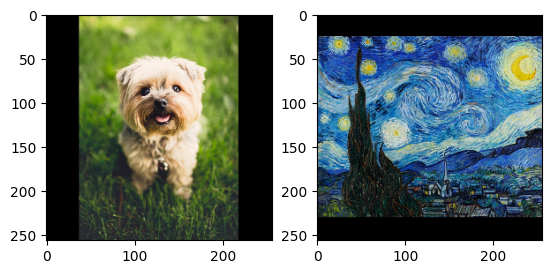

In [13]:
%matplotlib inline

content_image = cv2.resize(cv2.imread('C:/Users/prajw/Downloads/image-from-rawpixel-id-3282175-jpeg (1).jpg'), (256,256))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread('C:/Users/prajw/Downloads/image-from-rawpixel-id-537438-jpeg (1).jpg'), (256,256))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
opt = tf.optimizers.Adam(learning_rate = 0.01, beta_1=0.99, epsilon=0.1)


In [21]:
def loss_object(style_outputs, content_outputs, style_target, content_target):
    style_weight = 0.01
    content_weight = 0.1
    content_loss = tf.reduce_mean((content_outputs - content_target)**2)
    style_loss = tf.add_n(tf.reduce_mean((output_ - target_)**2) for output_,target_ in zip(style_outputs,style_target))
    total_loss = content_weight*content_loss + style_weight*style_loss
    return total_loss

In [22]:
vgg_model = load_vgg()
content_target = vgg_model(np.array([content_image * 255]))[0]
style_target = vgg_model(np.array([style_image * 255]))[1]

ValueError: Layer count mismatch when loading weights from file. Model expected 19 layers, found 16 saved layers.

In [23]:
def train_step(image, epoch):
    with tf.GradientTape() as tape:
        output = vgg_model(image*255)
        loss = loss_object(output[1], output[2], style_target, content_target)
    gradient = tape.gradient(loss, image)
    opt.apply_gradients[((gradient, image))]
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

    if epoch%10 == 0:
        tf.print(f"Loss: {loss}")

In [24]:
EPOCHS = 50
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
    train_step(image,i) 

NameError: name 'vgg_model' is not defined

In [26]:
import PIL
tensor = image*255
tensor = np.array(tensor, dtype=np.unit8)
if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

tensor = PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()

AttributeError: module 'numpy' has no attribute 'unit16'